In [ ]:
%pylab inline
import os
import glob
import pandas as pd
import time
import sklearn
import seaborn as sns
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


Given that we already have the grants and abstracts merged from 2009 to 2018

In [ ]:
grants_df=pd.read_csv('grants_w_abs_2009_2018.csv', skipinitialspace=True, low_memory=False)

In [ ]:
grants_df['Grant_Year']=pd.to_datetime(grants_df['BUDGET_START_DATE']).dt.year
grants_df['ABSTRACT']=grants_df['ABSTRACT'].str.lower()
grants_df['PROJECT_TITLE']=grants_df['PROJECT_TITLE'].str.lower()

In [ ]:
#filter out the data based on renewable energy types first
RE_type='solar | wind power | wind turbine | biomass | biofuel | geothermal'
RE_ppyr1=grants_df[(grants_df['Grant_Year'].between(2009,2018)) & (grants_df['ABSTRACT'].isna()) & (grants_df['PROJECT_TITLE'].str.contains(RE_type))]
non_emptyab=grants_df[grants_df['ABSTRACT'].notna()]
RE_ppyr2=non_emptyab[(non_emptyab['Grant_Year'].between(2009,2018)) & (non_emptyab['ABSTRACT'].str.contains(RE_type))]
combo_df=pd.concat([RE_ppyr1, RE_ppyr2])

In [ ]:
#'PROJECT_START_DATE', 'PROJECT_END_DATE'
#'BUDGET_START_DATE', 'BUDGET_END_DATE'
#'FY_TOTAL_COST'

In [ ]:
grants_df=combo_df
#Get the difference between project start and end times for project duration
grants_df['project_start']=pd.to_datetime(grants_df['PROJECT_START_DATE'])
grants_df['project_end']=pd.to_datetime(grants_df['PROJECT_END_DATE'])
grants_df['project_days'] = (grants_df['project_end'] - grants_df['project_start']).abs().dt.days
grants_df['project_years']=grants_df['project_days']/365

In [ ]:
#Get the difference between budget start and end times for budget duration
grants_df['budget_start']=pd.to_datetime(grants_df['BUDGET_START_DATE'])
grants_df['budget_end']=pd.to_datetime(grants_df['BUDGET_END_DATE'])
grants_df['budget_days'] = (grants_df['budget_end'] - grants_df['budget_start']).abs().dt.days
grants_df['budget_years']=grants_df['budget_days']/365

In [ ]:
df_cluster=grants_df[['budget_years', 'project_years', 'FY_TOTAL_COST']]
#convert the cost to millions
df_cluster['FY_TOTAL_COST']=df_cluster['FY_TOTAL_COST']/1e6
df_cluster.isna().sum()

budget_years       0
project_years     61
FY_TOTAL_COST    118
dtype: int64

In [ ]:
new_cluster=df_cluster.dropna()

Chose a k=6 because there was little change in the sum of squared distances from the elbow method plot

In [ ]:
# Run cluster algorithm
kmeans = KMeans(n_clusters=6) #how many clusters we want
kmeans.fit(new_cluster)
labels = kmeans.predict(new_cluster)

In [ ]:
# Check centroid values the algorithm generated for the final clusters
print(kmeans.cluster_centers_) 

[[ 1.07841184  2.17797964  0.18482941]
 [ 1.05252716 21.16929617  0.49029241]
 [ 1.24043292  4.78382523  0.42682508]
 [ 1.02319635 31.88493151  0.32754053]
 [ 1.16594912 14.02747554  0.38530534]
 [ 1.63420955  8.65679378  0.39794143]]


In [ ]:
# Add back to original data, labels is a np array
new_cluster['clusters'] = labels

In [ ]:
# Let's analyze the clusters
print(new_cluster.groupby(['clusters']).mean())

          budget_years  project_years  FY_TOTAL_COST
clusters                                            
0             1.078412       2.177980       0.184829
1             1.052527      21.169296       0.490292
2             1.240433       4.783825       0.426825
3             1.023196      31.884932       0.327541
4             1.165949      14.027476       0.385305
5             1.634210       8.656794       0.397941


The Project Duration vs Funding Amount for Renewable Energy Grants plot was used on slide 12 of our presentation

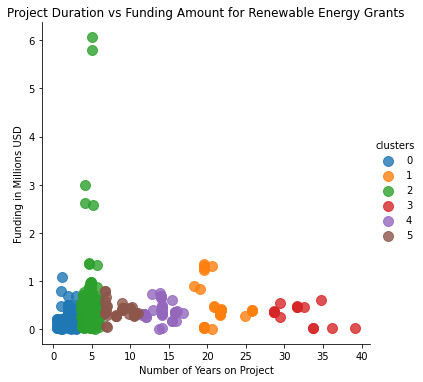

In [ ]:
# Scatter plot of Number of Terms and Total Cost
sns.lmplot('project_years', 'FY_TOTAL_COST', 
           data=new_cluster, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Project Duration vs Funding Amount for Renewable Energy Grants')
plt.xlabel('Number of Years on Project')
plt.ylabel('Funding in Millions USD')
plt.savefig('RE_kmeans.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#Some of these projects started back in 1977!
grants_df[grants_df['project_days']>14000]

,Unnamed: 0,PROJECT_ID,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,...,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ABSTRACT,Grant_Year,project_start,project_end,project_days,budget_start,budget_end,budget_days
282374,282374,440000,Atlases; Biological; Biota; Birth; Blood Pres...,chronobiologic markers for lab medicine and th...,HHS,NIH,NIGMS,4K06GM013981-49,7/1/1977,8/31/2016,...,35991.0,NaN,a. specific aimsthe original aims have not bee...,2011.0,1977-07-01,2016-08-31,14306.0,2011-09-01,2012-08-31,365


In [ ]:
print(kmeans.inertia_)

114281880.34555224


In [ ]:
new_cluster.drop(['clusters'], axis=1, inplace=True)

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(new_cluster)
    Sum_of_squared_distances.append(km.inertia_)

## try to choose a k near inflection where change in sum of squared distances becomes negligible

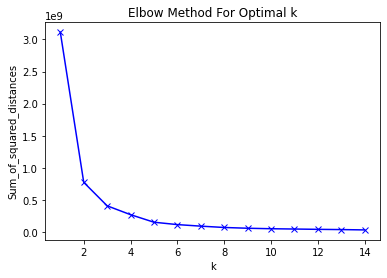

In [ ]:
# Plot the result: Elbow plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

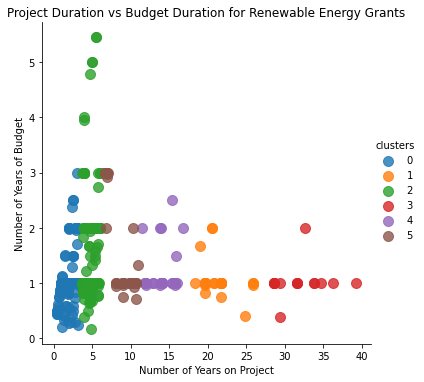

In [ ]:
sns.lmplot('project_years', 'budget_years', 
           data=new_cluster, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Project Duration vs Budget Duration for Renewable Energy Grants')
plt.xlabel('Number of Years on Project')
plt.ylabel('Number of Years of Budget')
plt.show()

In [ ]:
#seems to be a typo in one of the dates 
grants_df[(grants_df['PROJECT_START_DATE']=='6/30/3018') | (grants_df['PROJECT_END_DATE']=='6/30/3018')]

,Unnamed: 0,PROJECT_ID,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,...,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ABSTRACT,Grant_Year,project_start
660092,660092,813005,Acute; Affect; American; Animal Model; Area; A...,imaging glucose uptake and metabolism in tbi m...,DOD,CNRM,NaN,C308049-10.01-60855,2/1/2016,6/30/3018,...,\tUNITED STATES,NaN,NaN,NaN,2015,237691.0,NaN,subject: traumatic brain injury (tbi) is one o...,NaN,2016-02-01
